# Simulated Annealing


In [13]:
%matplotlib inline

import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import random as rm
import numpy as np
import time

# Add the sibling folders
import sys, os
sys.path.insert(0, os.path.abspath('../..'))
import src.utils as ut

# Plot libraries and tables
from IPython.display import HTML, display
import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()

Let's define a basic NN, made out of two layers: the first one has 100 neurons, while the second one 50.

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Define all the components
        # Basic two-layer network
        self.fc1 = nn.Linear(28 * 28, 200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 10)
        
    def forward(self, x):        
        # Get the batch size
        in_size = x.size(0)
        
        # Flatten data, -1 is inferred from the other dimensions
        x = x.view(in_size, -1) 
        
        # Forward rule
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.softmax(x, dim=1)

## The algorithm
The first implementation uses the **whole training set**, in order to avoid noisy evaluations: in such a way we are sure to make the best choice. 
The epsilon variable allows to set the maximum movement in every direction. Each movement is done by creating a tensor for each layer called $ \Delta_k(w)$.

$$ w'  = w - \epsilon \Delta(w)  $$

where each value of the tensor  $ \Delta(w) $ is sampled from the distribution $ U (-1, 1) $. 

In the following implementation I wanted to try a first implementation without temperature: if $ L(w') > L(w) $ the opposite direction is chosen, i.e.

$$ w''  = w + \epsilon \ \Delta(w)  $$



In [3]:
def full_train_SA_noT(trainloader, model, accuracy_before, gpu=True):
    model.train()
    
    # List to store the opposite direction - \Delta(w) for each layer
    inverse = []
    
    for param in net.parameters():
        # Replicate the tensor
        tensor_size = param.data.size()
        move = torch.zeros(tensor_size)
        # Send it to the GPU
        if gpu:
            move = move.cuda()
        # Generate move
        move = move.uniform_(-1, 1).mul(epsilon) * param.data
        # Stepback is saved
        inverse.append(move.mul(-2))
        # Move the parameters
        param.data.add_(move)
    
    # Evaluate the accuracy 
    new_accuracy = ut.test_train(train_loader, net)[1]

    if new_accuracy < accuracy_before:
        for k, param in enumerate(net.parameters()):
            param.data.add_(inverse[k])

        new_accuracy = ut.test_train(train_loader, net)[1]
    
    print("New accuracy: ", new_accuracy)
    return new_accuracy

Looking at the results, it can be seen that both the directions do not sometimes improve the accuracy. This technique allows to avoid overwriting the values if $ L(w'') > L(w') $, but in the meanwhile it makes the worst choice.

Now we can

In [4]:
def full_train_SA(trainloader, model, initial_accuracy, T, gpu=True):
    model.train()
    
    # List used to keep the move to get back to the first
    inverse = []
    
    # First move
    for param in net.parameters():
        # Replicate the tensor
        tensor_size = param.data.size()
        move = torch.zeros(tensor_size)
        # Send it to the GPU
        if gpu:
            move = move.cuda()
        # Generate move
        move = move.uniform_(-1, 1).mul(epsilon) * param.data
        # Stepback is saved
        inverse.append(move.mul(-1)) 
        # Move the parameters
        param.data.add_(move)
    # Evaluate the accuracy 
    first_accuracy = ut.test_train(train_loader, net)[1]
    print("First accuracy: ", first_accuracy)
    
    # Second move
    for k, param in enumerate(net.parameters()):
        param.data.add_(inverse[k].mul(2))
        inverse[k] = inverse[k].mul(-1)
    second_accuracy = ut.test_train(train_loader, net)[1]
    print("Second accuracy:", second_accuracy)
    
    # Get back if the first accuracy is better
    if first_accuracy > second_accuracy:
        for k, param in enumerate(net.parameters()):
            param.data.add_(inverse[k].mul(2))
            inverse[k] = inverse[k].mul(-1)
        new_accuracy = first_accuracy
    else: new_accuracy = second_accuracy
    
    # Accept a worse solution according to temperature
    # T = 0 => non accetto soluzioni peggiorative
    if new_accuracy < initial_accuracy and rm.uniform(0, 1) > T:
        for k, param in enumerate(net.parameters()):
            param.data.add_(inverse[k])
        new_accuracy = initial_accuracy
        
    del move, inverse
    print("Final accuracy:", new_accuracy)
    return new_accuracy


In [21]:
epsilon = 10e-2
train_loader, test_loader = ut.load_dataset(dataset_name='mnist', minibatch=4096)

# Testing the first method
starting_time = time.time()
net = Net().cuda()
accuracy = ut.test_train(train_loader, net)[1]
training_set_measurements, validation_set_measurements, times = [], [], []

# Train
for epoch in range(10):
    print("Epoch: ", epoch)
    accuracy = full_train_SA_noT(train_loader, net, accuracy)
    val =  ut.test(test_loader, net)[1]
    training_set_measurements.append(accuracy)
    validation_set_measurements.append(val)
    times.append(time.time() - starting_time)
    print("Validation test:", val)
    
np.savez('no_temperature',
            training_set_measurements=training_set_measurements,
            validation_set_measurements=validation_set_measurements,
            times=times)

Epoch:  0
New accuracy:  0.11846666666666666
Validation test: 0.1194
Epoch:  1
New accuracy:  0.11863333333333333
Validation test: 0.1185
Epoch:  2
New accuracy:  0.12688333333333332
Validation test: 0.1275
Epoch:  3
New accuracy:  0.12816666666666668
Validation test: 0.1293
Epoch:  4
New accuracy:  0.12893333333333334
Validation test: 0.1305
Epoch:  5
New accuracy:  0.13395
Validation test: 0.1376
Epoch:  6
New accuracy:  0.13598333333333334
Validation test: 0.1384
Epoch:  7
New accuracy:  0.14166666666666666
Validation test: 0.1443
Epoch:  8
New accuracy:  0.14053333333333334
Validation test: 0.142
Epoch:  9
New accuracy:  0.13788333333333333
Validation test: 0.1413


In [22]:
epsilon = 10e-2
train_loader, test_loader = ut.load_dataset(dataset_name='mnist', minibatch=4096)

# Testing the second method
net = Net().cuda()
accuracy = ut.test_train(train_loader, net)[1]
training_set_measurements, validation_set_measurements, times = [], [], []
starting_time = time.time()
for epoch in range(10):
    print("Epoch: ", epoch)
    accuracy = full_train_SA(train_loader, net, accuracy, 0)
    val =  ut.test(test_loader, net)[1]
    training_set_measurements.append(accuracy)
    validation_set_measurements.append(val)
    times.append(time.time() - starting_time)
    print("Validation test:", val)
    
np.savez('T=0',
            training_set_measurements=training_set_measurements,
            validation_set_measurements=validation_set_measurements,
            times=times)

Epoch:  0
First accuracy:  0.05655
Second accuracy: 0.060283333333333335
Final accuracy: 0.060283333333333335
Validation test: 0.0596
Epoch:  1
First accuracy:  0.06118333333333333
Second accuracy: 0.06116666666666667
Final accuracy: 0.06118333333333333
Validation test: 0.0615
Epoch:  2
First accuracy:  0.0642
Second accuracy: 0.05955
Final accuracy: 0.0642
Validation test: 0.0645
Epoch:  3
First accuracy:  0.06316666666666666
Second accuracy: 0.06508333333333334
Final accuracy: 0.06508333333333334
Validation test: 0.065
Epoch:  4
First accuracy:  0.07153333333333334
Second accuracy: 0.06211666666666667
Final accuracy: 0.07153333333333334
Validation test: 0.0724
Epoch:  5
First accuracy:  0.0718
Second accuracy: 0.07143333333333333
Final accuracy: 0.0718
Validation test: 0.0724
Epoch:  6
First accuracy:  0.0643
Second accuracy: 0.07988333333333333
Final accuracy: 0.07988333333333333
Validation test: 0.0802
Epoch:  7
First accuracy:  0.08378333333333333
Second accuracy: 0.07631666666666

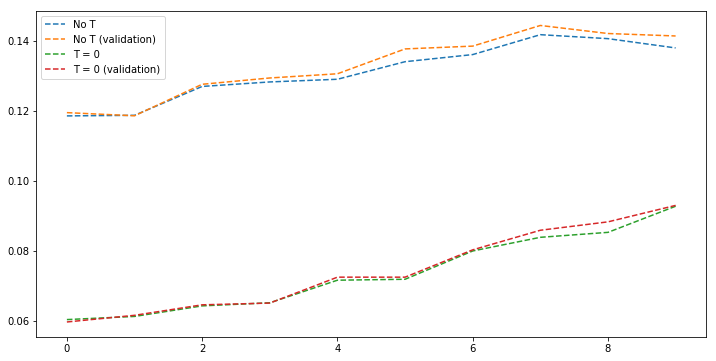

In [24]:
no_T = np.load('no_temperature.npz')
T_0 = np.load('T=0.npz')

fix, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(0, len(no_T['training_set_measurements'])), no_T['training_set_measurements'], '--', label='No T')
ax.plot(np.arange(0, len(no_T['validation_set_measurements'])), no_T['validation_set_measurements'], '--', label='No T (validation)')
ax.plot(np.arange(0, len(T_0['training_set_measurements'])), T_0['training_set_measurements'], '--', label='T = 0')
ax.plot(np.arange(0, len(T_0['validation_set_measurements'])), T_0['validation_set_measurements'], '--', label='T = 0 (validation)')

ax.legend()
plt.show()

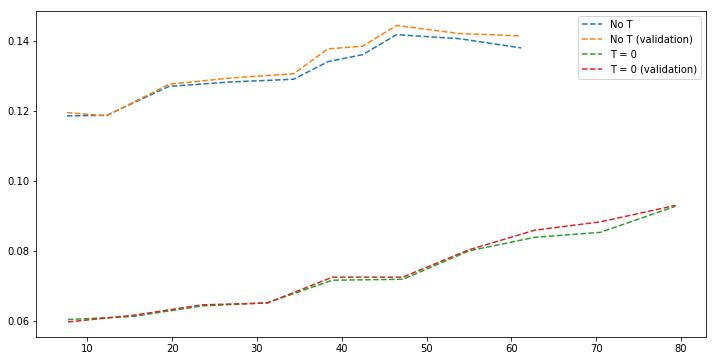

In [25]:
fix, ax = plt.subplots(figsize=(12, 6))
ax.plot(no_T['times'], no_T['training_set_measurements'], '--', label='No T')
ax.plot(no_T['times'], no_T['validation_set_measurements'], '--', label='No T (validation)')
ax.plot(T_0['times'], T_0['training_set_measurements'], '--', label='T = 0')
ax.plot(T_0['times'], T_0['validation_set_measurements'], '--', label='T = 0 (validation)')

ax.legend()
plt.show()

## SGD comparison
Running the same network with the SGD algorithm to compare the results.

In [ ]:
train_loader, test_loader = ut.load_dataset(dataset_name='mnist', minibatch=512)
net = Net().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 300):    
    ut.train(train_loader, net, optimizer, criterion, 1)
    print(ut.test_train(train_loader, net))
    print("Epoch: ", epoch, "value:", ut.test(test_loader, net))

## Mixing SGD and SA
We have already seen that the cross entropy tries to approximate the accuracy. Another approach can benefit of both the approaches.

In [ ]:
train_loader, test_loader = ut.load_dataset(dataset_name='mnist', minibatch=512)
net = Net().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 100):    
    train(train_loader, net, optimizer, criterion, 1)
    print(ut.test_train(train_loader, net))
    print("Epoch: ", epoch, "value:", ut.test(test_loader, net))

accuracy = ut.test_train(train_loader, net)[1]
for epoch in range(1000):
    print("Epoch: ", epoch)
    accuracy = full_train_SA(train_loader, net, accuracy, 0)
    print("Validation test:", ut.test(test_loader, net))
    